### In class practice
 - run regression of total spent by day over average price by day
 - use the same code as in the regression of total spent by week over average price by week
### setting up data and utility functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def add_date_cols(baskets):
    baskets['datetime'] = pd.to_datetime(baskets['placed_at'])
    baskets['year'] = baskets["datetime"].dt.year
    baskets['month'] = baskets["datetime"].dt.month
    baskets['date'] = baskets["datetime"].dt.date
    baskets['day'] = baskets["datetime"].dt.day
    baskets['hour'] = baskets["datetime"].dt.hour
    baskets['weekday'] = baskets["datetime"].dt.weekday
    baskets['year_month'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%m"))
    baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
    baskets['year_week'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
    baskets['week_num'] = baskets["datetime"].apply(lambda t: int(t.strftime("%W"))) 
    baskets['iso_week_num'] = baskets["datetime"].dt.isocalendar().week # this returns week number 52 for Jan 1, 2021, not 0 which is what we want
    baskets['cum_week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
    return baskets
def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat','nunique'), 
        num_sub_cats = ('sub_cat','nunique'),
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    return merchant_attributes

### preparing the analysis table
 - unit of study is SKU, so we may want to start with a table for SKU attributes, each row for one SKU


In [3]:
def get_sku_attributes(baskets):
    sku_attributes = baskets.groupby(['sku_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_merchants = ('merchant_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        first_week = ('week_num', 'min'), 
        last_week = ('week_num', 'max'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
    ).reset_index()
    sku_attributes['avg_spent_per_order'] = sku_attributes.total_spent / sku_attributes.num_orders
    sku_attributes['tenure_month'] = sku_attributes.last_month - sku_attributes.first_month +1
    return sku_attributes

In [4]:
def get_skus_by_day(baskets):
    skus_by_day = baskets.groupby(['sku_id','date']).agg(
        avg_price_by_day = ('price','mean'),
        total_spent_by_day = ('spent', 'sum'),
        num_order_by_day = ('order_id', 'nunique'), 
        num_merchants_by_day = ('merchant_id', 'nunique'),
    ).reset_index()
    return skus_by_day

In [5]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [6]:
sku_day = get_skus_by_day(baskets)

In [7]:
sku_day.describe()

,sku_id,avg_price_by_day,total_spent_by_day,num_order_by_day,num_merchants_by_day
count,170491.000000,1.704910e+05,1.704910e+05,170491.000000,170491.000000
mean,1104.127655,1.029601e+05,4.977063e+05,2.888305,2.415688
std,409.729982,2.628746e+05,1.414106e+06,4.300960,3.173606
min,1.000000,1.331019e+02,8.400000e+02,1.000000,1.000000
25%,851.000000,1.600000e+04,4.950000e+04,1.000000,1.000000
50%,1116.000000,4.100000e+04,1.260000e+05,1.000000,1.000000
75%,1445.000000,1.180000e+05,3.300000e+05,3.000000,2.000000
max,1860.000000,4.240000e+06,4.506000e+07,68.000000,56.000000


In [8]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]
top_skus.head(20)

,sku_id
1503,1504
866,867
1512,1513
873,874
971,972
984,985
970,971
991,992
1337,1338
972,973


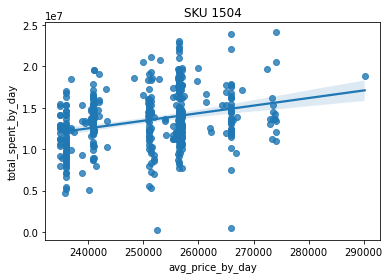

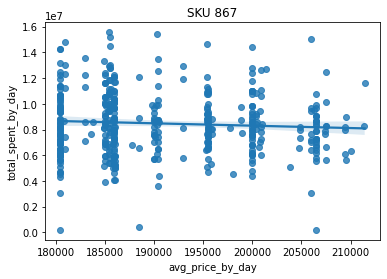

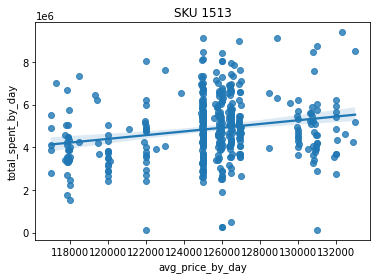

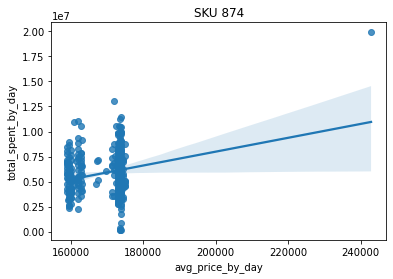

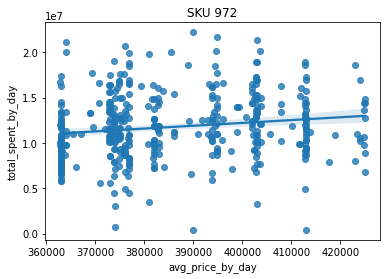

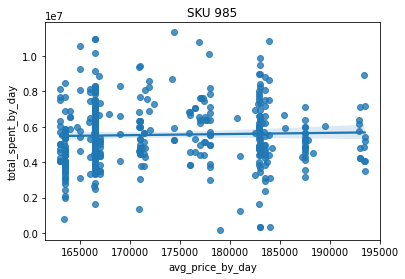

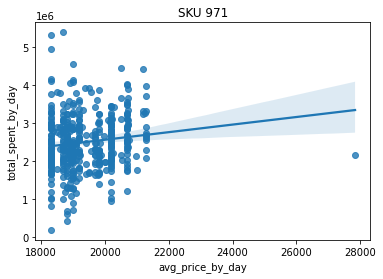

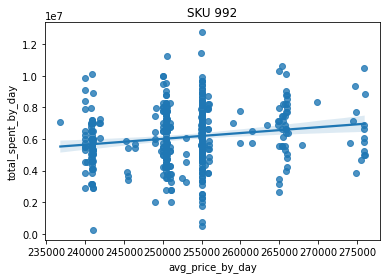

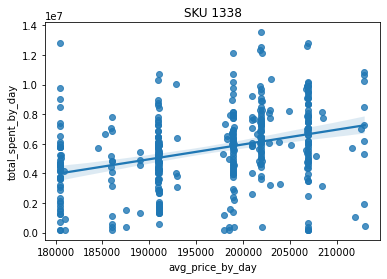

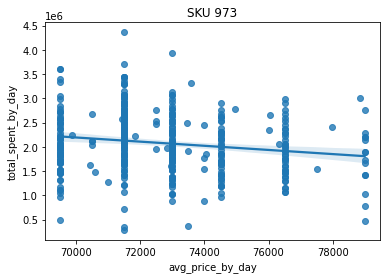

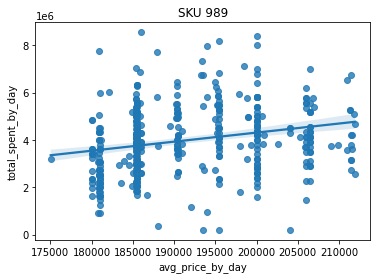

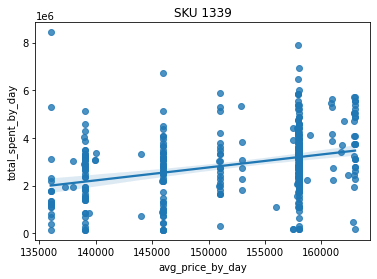

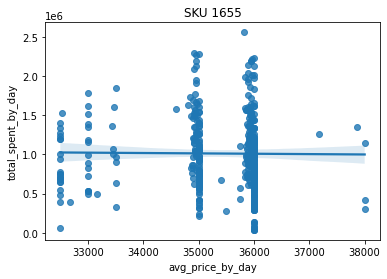

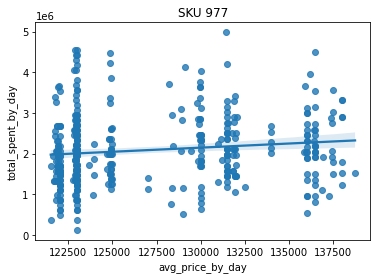

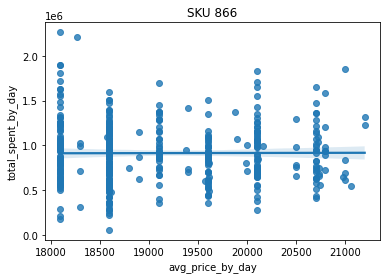

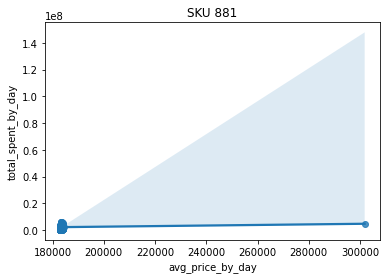

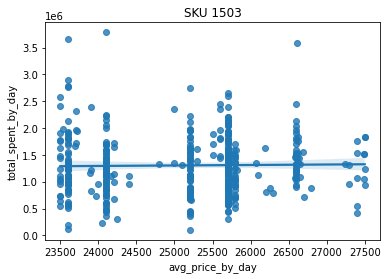

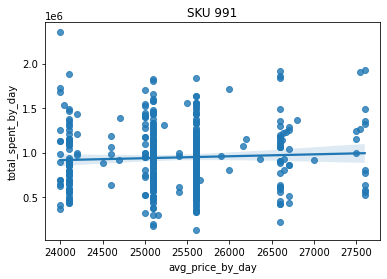

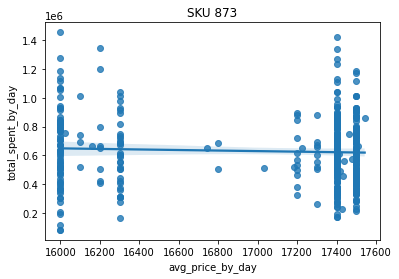

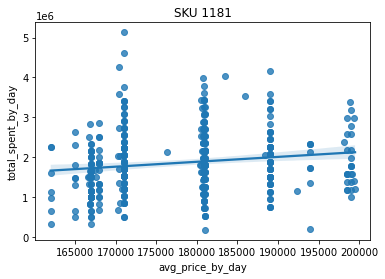

In [9]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    plt.figure(sku_id)
    sns.regplot(data = sku_day[sku_day["sku_id"] ==sku_id], x="avg_price_by_day",y="total_spent_by_day").set(title = "SKU " + str(sku_id))

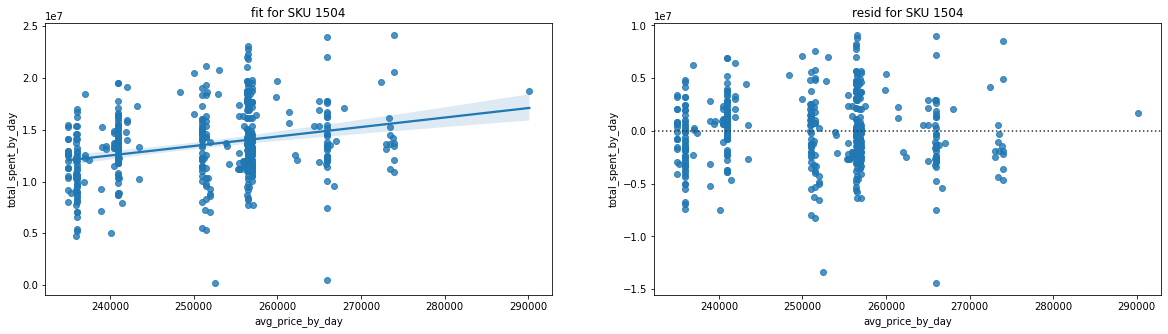

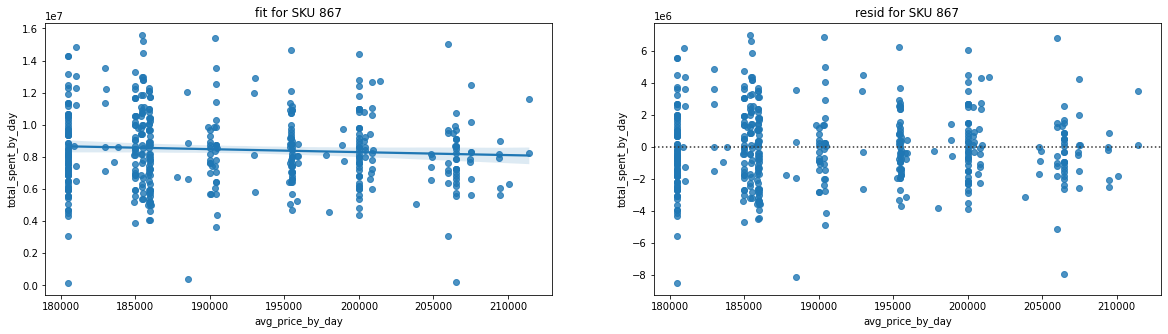

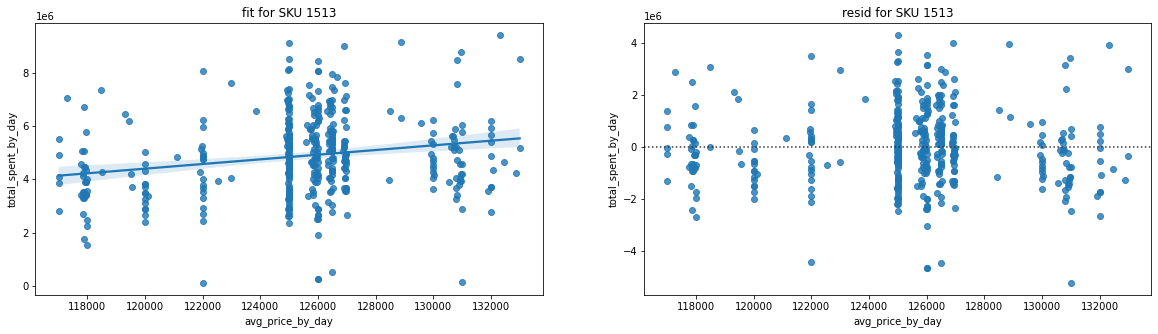

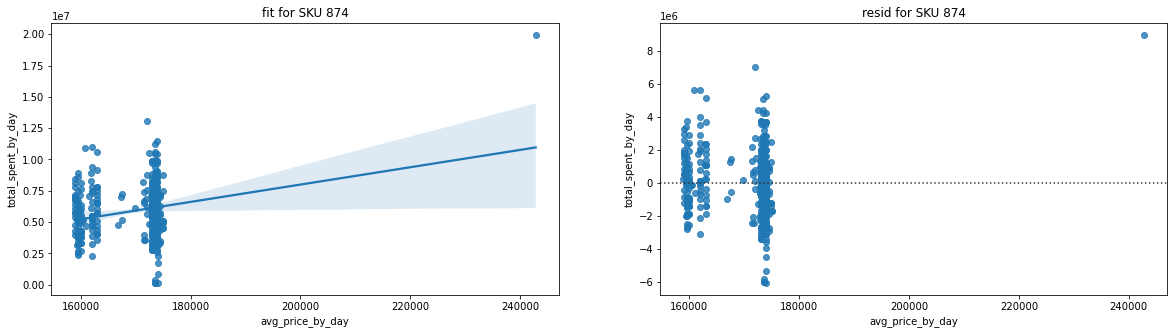

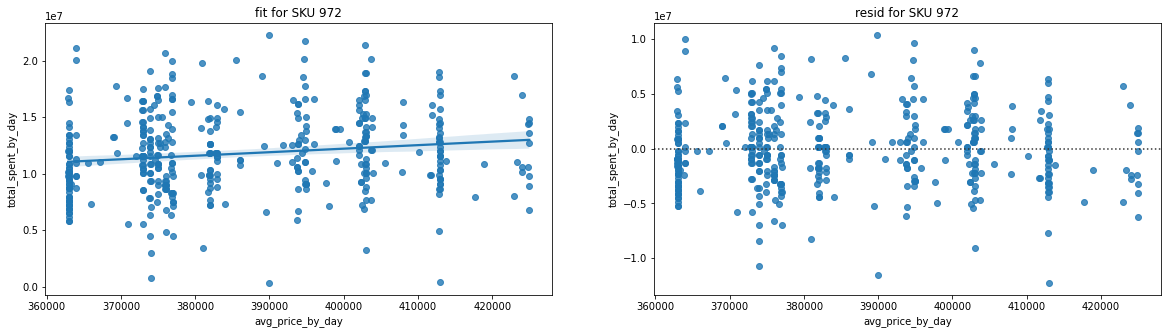

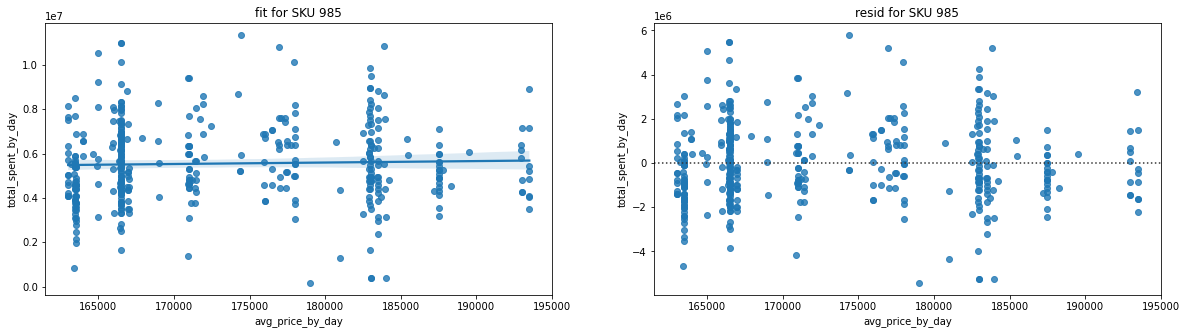

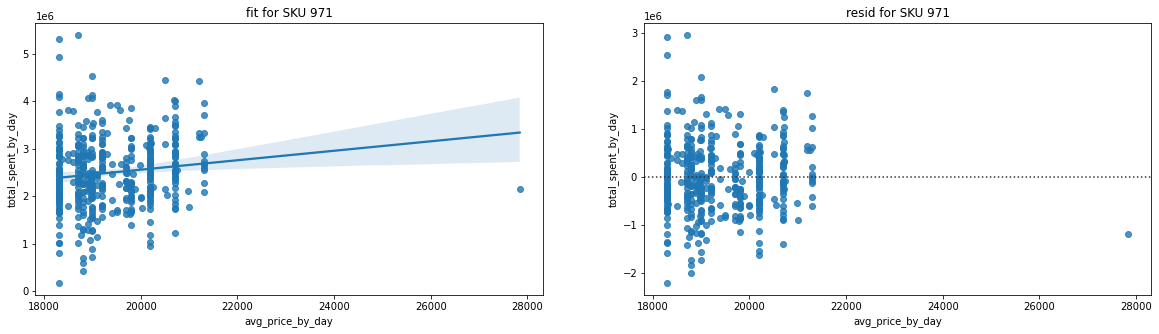

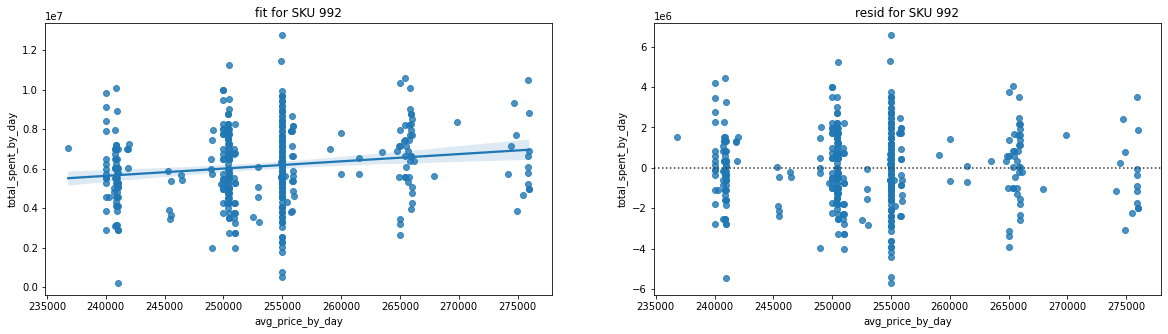

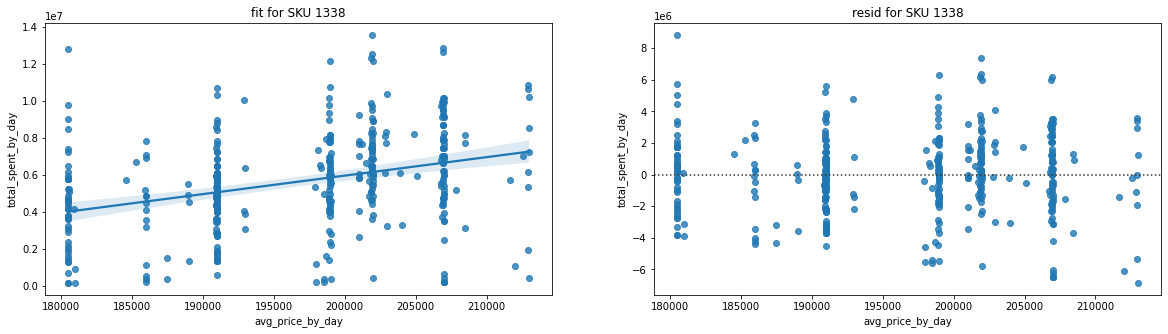

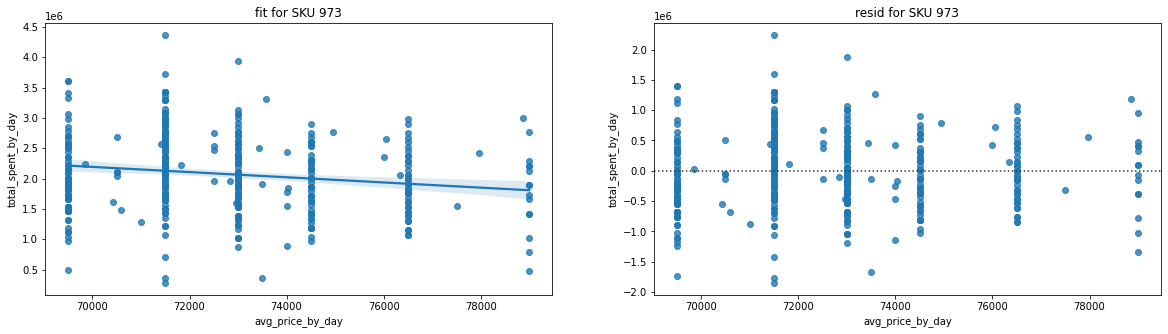

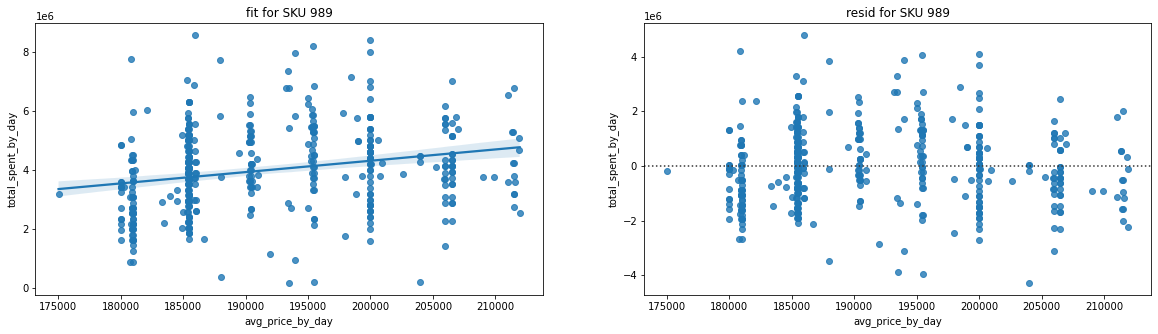

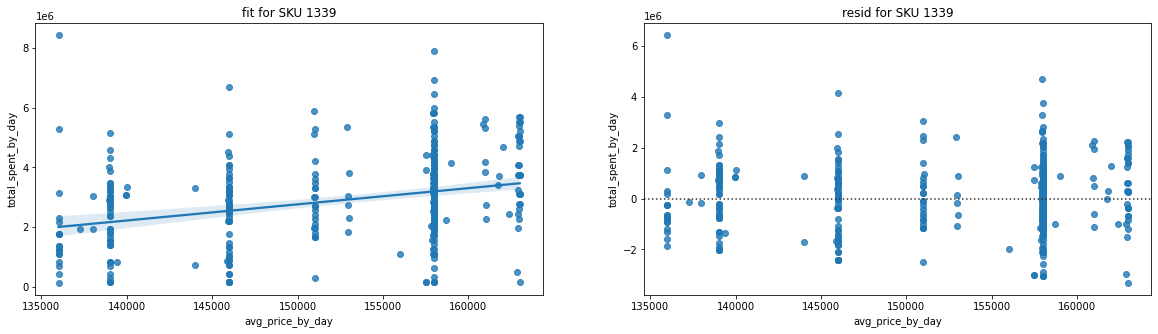

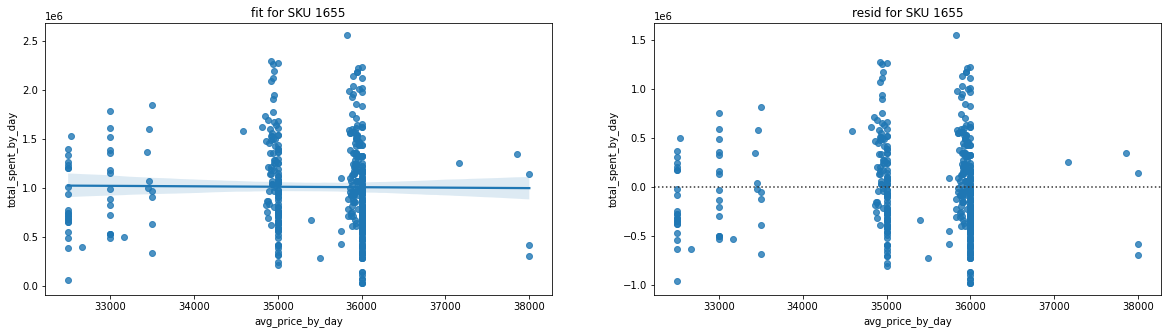

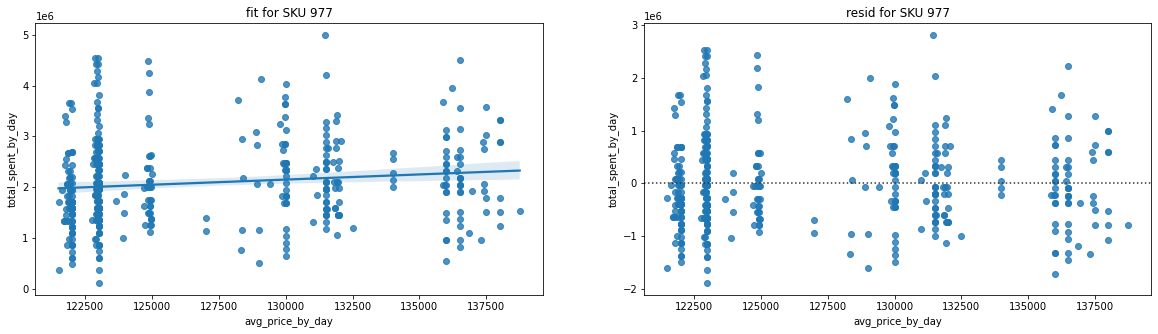

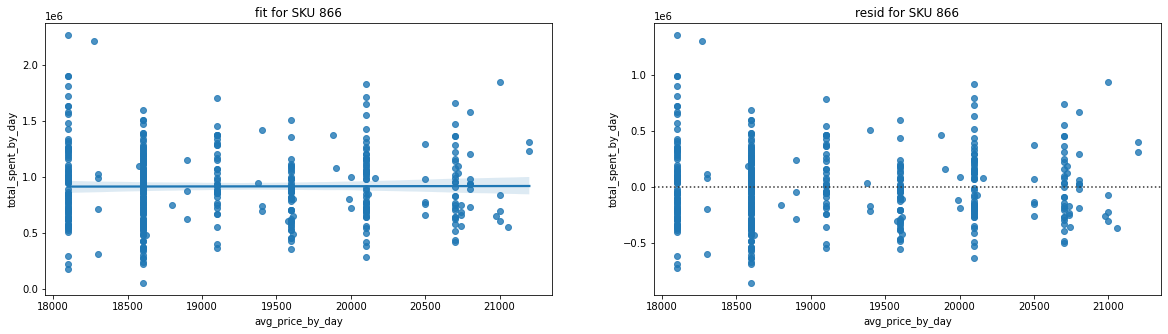

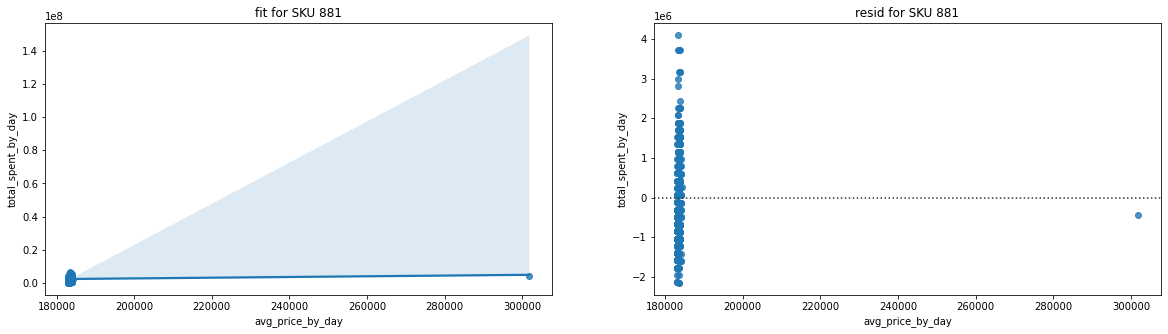

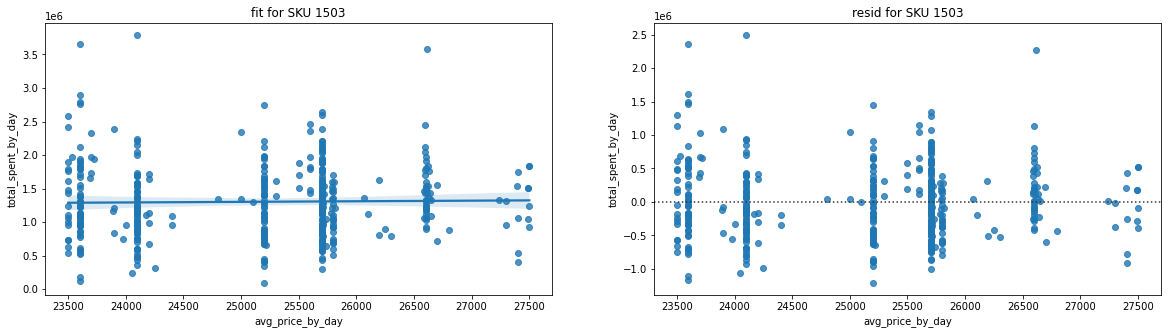

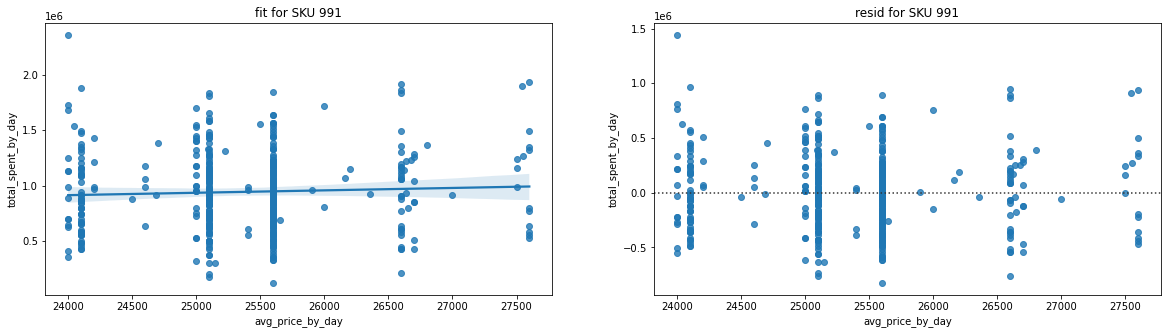

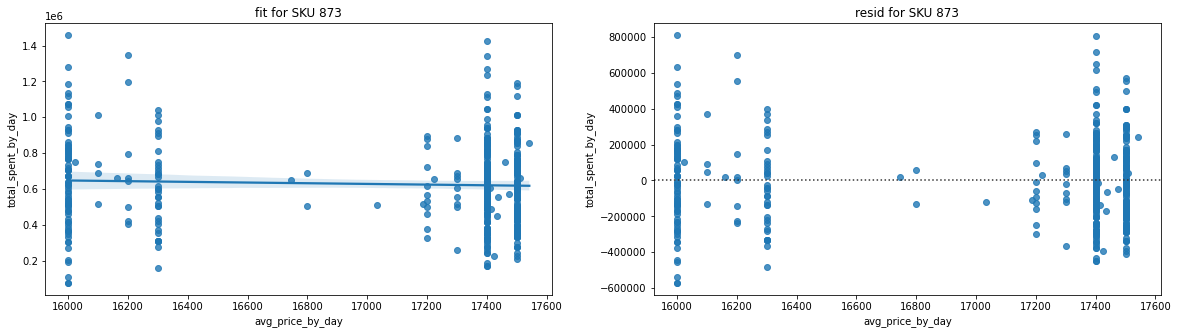

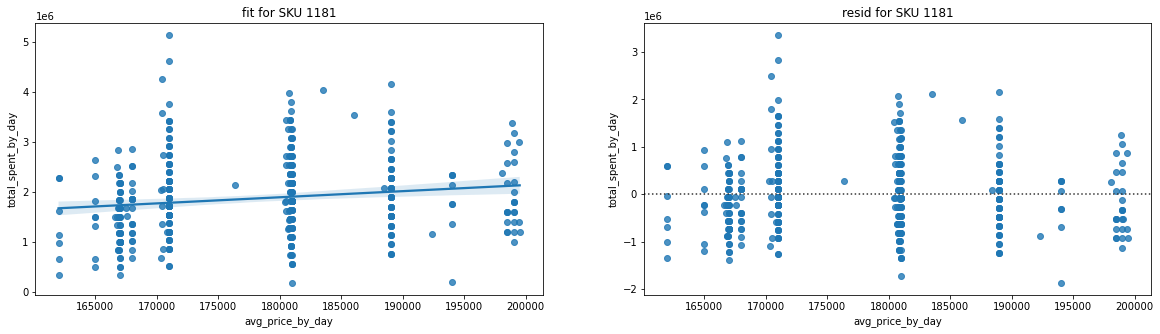

In [10]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    #plt.figure(sku_id)
    f, axes = plt.subplots(1, 2, figsize = (20,5))
    sns.regplot(data = sku_day[sku_day["sku_id"] ==sku_id], x="avg_price_by_day",y="total_spent_by_day", ax=axes[0])
    sns.residplot(data = sku_day[sku_day["sku_id"] ==sku_id], x="avg_price_by_day",y="total_spent_by_day",ax=axes[1])
    axes[0].set(title = "fit for SKU " + str(sku_id))
    axes[1].set(title = "resid for SKU " + str(sku_id))


### conclusion: 
 - regression of total spent over average price at daily resolution does not make much sense